In [1]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten

from datetime import datetime

In [2]:
tf.get_logger().setLevel("ERROR") 

In [3]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [4]:
def addWord(word, pos, ner):
    """
    Convert a word into a word token and add supplied NER and POS labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, pos label, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['posToken'] = [pos] + ['posX'] * (tokenLength - 1)
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    
    return addDict


In [5]:
addWord('protest', 'VB', 'O')

{'wordToken': ['protest'],
 'posToken': ['VB'],
 'nerToken': ['O'],
 'tokenLength': 1}

In [6]:
import json
import config
vocab_params = config.VocabParameters()
training_params = config.TrainingParameters()
eval_params = config.EvalParameters()

with open(vocab_params.data_dir+ '/train.json') as infile:
    json_data = json.load(infile)
len(json_data)


68124

In [7]:
import pandas as pd
train_df = pd.DataFrame(json_data )
train_df_sorted = train_df.sort_values(by=['docid','id'], ascending = True)
train_df_sorted.head(10)

,id,docid,relation,token,subj_start,subj_end,obj_start,obj_end,subj_type,obj_type,stanford_pos,stanford_ner,stanford_head,stanford_deprel
42795,61b3a65fb960f284ebac,03c67d9ee4bf4ed33cbeddaa3a7b82cc,no_relation,"[Red, Sox, 12, ,, Athletics, 2]",0,1,4,4,ORGANIZATION,ORGANIZATION,"[NNP, NNP, CD, ,, NNP, CD]","[ORGANIZATION, ORGANIZATION, NUMBER, O, ORGANI...","[2, 0, 2, 2, 2, 5]","[compound, ROOT, nummod, punct, appos, nummod]"
46757,61b3a65fb9080a05b4ee,15df2fc6a9a895432237cb2bdfcbd1b5,no_relation,"[Thomas, ', assertion, of, 85, %, reporters, v...",41,43,31,31,ORGANIZATION,DATE,"[NNP, POS, NN, IN, CD, NN, NNS, VBP, JJ, VBZ, ...","[PERSON, O, O, O, PERCENT, PERCENT, O, O, MISC...","[3, 1, 8, 7, 6, 7, 3, 0, 12, 12, 12, 8, 12, 18...","[nmod:poss, case, nsubj, case, compound, amod,..."
36591,61b3a65fb9883fc52f01,274e368f381c1476fe0da7f201bfc331,no_relation,"[Kerry, did, his, duty, and, did, it, well, .]",2,2,0,0,PERSON,PERSON,"[NNP, VBD, PRP$, NN, CC, VBD, PRP, RB, .]","[PERSON, O, O, O, O, O, O, O, O]","[2, 0, 4, 2, 2, 2, 6, 6, 2]","[nsubj, ROOT, nmod:poss, dobj, cc, conj, dobj,..."
22262,61b3a65fb937b50fc05a,409fa10efff702a41701bdddab89a2dd,no_relation,"[This, August, ,, Moschella, 's, name, came, u...",17,20,39,40,ORGANIZATION,STATE_OR_PROVINCE,"[DT, NNP, ,, NNP, POS, NN, VBD, RP, IN, DT, NN...","[DATE, DATE, O, PERSON, O, O, O, O, O, O, O, O...","[2, 0, 2, 6, 4, 7, 2, 7, 11, 11, 7, 15, 15, 15...","[det, ROOT, punct, nmod:poss, case, nsubj, acl..."
644,61b3a5f2e85a8088c7bb,78d7e406b6911492f6f7f122d1f112ad,org:top_members/employees,"[Sharpton, is, president, of, the, National, A...",5,7,0,0,ORGANIZATION,PERSON,"[NNP, VBZ, NN, IN, DT, NNP, NNP, NNP, .]","[PERSON, O, O, O, O, ORGANIZATION, ORGANIZATIO...","[3, 3, 0, 8, 8, 8, 8, 3, 3]","[nsubj, cop, ROOT, case, det, compound, compou..."
4138,61b3a37935aa6ae21928,84e924385dc7fb52b0417306a8500cb1,per:origin,"[She, is, an, American, actress, and, singer, .]",0,0,3,3,PERSON,NATIONALITY,"[PRP, VBZ, DT, JJ, NN, CC, NN, .]","[O, O, O, MISC, O, O, O, O]","[5, 5, 5, 5, 0, 5, 5, 5]","[nsubj, cop, det, amod, ROOT, cc, conj, punct]"
32520,61b3afb926759a7aef5a,84e924385dc7fb52b0417306a8500cb1,per:title,"[She, is, an, American, actress, and, singer, .]",0,0,6,6,PERSON,TITLE,"[PRP, VBZ, DT, JJ, NN, CC, NN, .]","[O, O, O, MISC, O, O, O, O]","[5, 5, 5, 5, 0, 5, 5, 5]","[nsubj, cop, det, amod, ROOT, cc, conj, punct]"
41668,61b3afb926aa0b82acad,84e924385dc7fb52b0417306a8500cb1,per:title,"[She, is, an, American, actress, and, singer, .]",0,0,4,4,PERSON,TITLE,"[PRP, VBZ, DT, JJ, NN, CC, NN, .]","[O, O, O, MISC, O, O, O, O]","[5, 5, 5, 5, 0, 5, 5, 5]","[nsubj, cop, det, amod, ROOT, cc, conj, punct]"
62446,61b3a65fb9b37d516ec9,85b9cca690e98657db2480fb91e05489,no_relation,"[Washington, ,, DC, :, American, Psychiatric, ...",4,6,7,7,ORGANIZATION,NUMBER,"[NNP, ,, NNP, :, NNP, NNP, NNP, CD, .]","[LOCATION, O, LOCATION, O, ORGANIZATION, ORGAN...","[0, 1, 1, 1, 7, 7, 1, 7, 1]","[ROOT, punct, appos, punct, compound, compound..."
66891,61b3a65fb9b8efc052b6,AFP_ENG_19941018.0328.LDC2007T07,no_relation,"[President, Bill, Clinton, 's, top, defense, a...",42,44,39,39,PERSON,PERSON,"[NNP, NNP, NNP, POS, JJ, NN, CC, JJ, NN, NNS, ...","[O, PERSON, PERSON, O, O, O, O, O, O, O, O, O,...","[3, 3, 6, 3, 6, 11, 6, 10, 10, 6, 0, 13, 46, 1...","[compound, compound, nmod:poss, case, amod, ns..."


In [8]:
"""
Read from above dataframe.  Each row in the dataframe represents a  
    
"""
max_length = 50
# lists for sentences, tokens, labels, etc.  
sentenceList = []
sentenceTokenList = []
posTokenList = []
nerTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
posTokens = ['[posCLS]']
nerTokens = ['[nerCLS]']

pos_column = 'stanford_pos'
ner_column = 'stanford_ner'
token_column = 'token'


for ind in train_df.index:    
    word_list = train_df[token_column][ind]
    ner_list = train_df[ner_column][ind]
    pos_list = train_df[pos_column][ind]

    for i in range(0,len(word_list)):

        word = word_list[i]
        ner = ner_list[i]
        pos = pos_list[i]
        addDict = addWord(word, pos, ner)
    
        sentenceTokens += addDict['wordToken']
        posTokens += addDict['posToken']
        nerTokens += addDict['nerToken']        

#     print(sentenceTokens, posTokens, nerTokens, "\n")
    
    sentenceLength = min(max_length -1, len(sentenceTokens))
    sentLengthList.append(sentenceLength)
    
    # Create space for at least a final '[SEP]' token
    if sentenceLength >= max_length - 1: 
        sentenceTokens = sentenceTokens[:max_length - 2]
        posTokens = posTokens[:max_length - 2]
        nerTokens = nerTokens[:max_length - 2]

    # add a ['SEP'] token and padding

    sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))

    posTokens += ['[posSEP]'] + ['[posPAD]'] * (max_length - 1 - len(posTokens) )
    nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )

    sentenceList.append(sentence)

    sentenceTokenList.append(sentenceTokens)

    bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
    bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
    bertSequenceIDs.append([0] * (max_length))

    posTokenList.append(posTokens)
    nerTokenList.append(nerTokens)

    sentence = ''
    sentenceTokens = ['[CLS]']
    posTokens = ['[posCLS]']
    nerTokens = ['[nerCLS]']

    sentence += ' ' + word

# The first two list elements need to be removed. 1st line in file is a-typical, and 2nd line does not end a sentence   
sentLengthList = sentLengthList[2:]
sentenceTokenList = sentenceTokenList[2:]
bertSentenceIDs = bertSentenceIDs[2:]
bertMasks = bertMasks[2:]
bertSequenceIDs = bertSequenceIDs[2:]
posTokenList = posTokenList[2:]
nerTokenList = nerTokenList[2:]

## Data Analysis

(array([1.0000e+00, 1.8000e+01, 1.5000e+01, 4.1000e+01, 5.2000e+01,
        8.3000e+01, 1.0400e+02, 1.8400e+02, 1.8300e+02, 2.2500e+02,
        2.8800e+02, 2.8300e+02, 3.0700e+02, 4.2600e+02, 4.4500e+02,
        0.0000e+00, 4.9200e+02, 5.8300e+02, 6.6000e+02, 6.8500e+02,
        6.7700e+02, 7.3600e+02, 9.6100e+02, 9.5000e+02, 1.0360e+03,
        1.1930e+03, 1.2540e+03, 1.3570e+03, 1.3160e+03, 1.3940e+03,
        1.4160e+03, 0.0000e+00, 1.4130e+03, 1.5450e+03, 1.4980e+03,
        1.5340e+03, 1.6630e+03, 1.5620e+03, 1.5780e+03, 1.7290e+03,
        1.5580e+03, 1.5800e+03, 1.5840e+03, 1.5740e+03, 1.4380e+03,
        1.3910e+03, 1.4520e+03, 2.7658e+04]),
 array([ 4.    ,  4.9375,  5.875 ,  6.8125,  7.75  ,  8.6875,  9.625 ,
        10.5625, 11.5   , 12.4375, 13.375 , 14.3125, 15.25  , 16.1875,
        17.125 , 18.0625, 19.    , 19.9375, 20.875 , 21.8125, 22.75  ,
        23.6875, 24.625 , 25.5625, 26.5   , 27.4375, 28.375 , 29.3125,
        30.25  , 31.1875, 32.125 , 33.0625, 34.    , 34.93

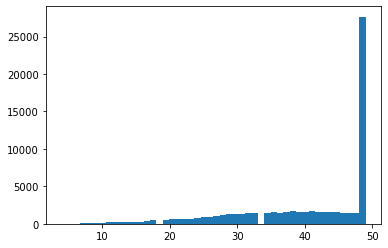

In [9]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

In [10]:
numSentences = len(bertSentenceIDs)

nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
nerClasses.columns = ['tag']
nerClasses.tag = pd.Categorical(nerClasses.tag)
nerClasses['cat'] = nerClasses.tag.cat.codes
nerClasses['sym'] = nerClasses.tag.cat.codes
nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1) 

In [11]:
x =nerClasses['tag'].unique()
x
for a in x:
    print(a)

[nerCLS]
O
ORGANIZATION
nerX
MISC
[nerSEP]
[nerPAD]
DATE
PERSON
NUMBER
LOCATION
ORDINAL
DURATION
SET
MONEY
TIME
PERCENT


In [12]:
nerClasses[nerClasses['cat']==1]

,tag,cat,sym
526,DURATION,1,1
718,DURATION,1,1
719,DURATION,1,1
831,DURATION,1,1
834,DURATION,1,1
...,...,...,...
3405474,DURATION,1,1
3405475,DURATION,1,1
3405476,DURATION,1,1
3405953,DURATION,1,1


In [13]:
column_values = nerClasses[["cat", "tag"]].values.ravel()
unique_values =  pd.unique(column_values)
unique_values

array([13, '[nerCLS]', 6, 'O', 8, 'ORGANIZATION', 16, 'nerX', 3, 'MISC',
       15, '[nerSEP]', 14, '[nerPAD]', 0, 'DATE', 10, 'PERSON', 5,
       'NUMBER', 2, 'LOCATION', 7, 'ORDINAL', 1, 'DURATION', 11, 'SET', 4,
       'MONEY', 12, 'TIME', 9, 'PERCENT'], dtype=object)

array([[<AxesSubplot:title={'center':'cat'}>]], dtype=object)

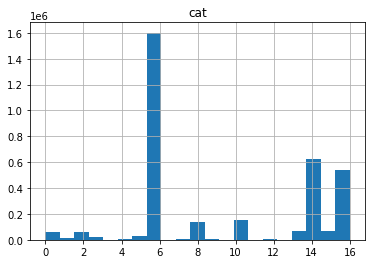

In [14]:
nerClasses[['cat']].hist(bins=21)

In [15]:
nerClasses['cat'].unique()

array([13,  6,  8, 16,  3, 15, 14,  0, 10,  5,  2,  7,  1, 11,  4, 12,  9],
      dtype=int8)

In [16]:
nerDistribution = (nerClasses.groupby(['tag', 'cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))

numNerClasses = nerDistribution.tag.nunique()

nerDistribution[nerDistribution['tag'] == 'O']

,tag,cat,occurences
102,O,0,0
103,O,1,0
104,O,2,0
105,O,3,0
106,O,4,0
107,O,5,0
108,O,6,1600623
109,O,7,0
110,O,8,0
111,O,9,0


In [17]:
nerClasses.groupby("tag").count()

,cat,sym
tag,,
DATE,58622,58622
DURATION,12584,12584
LOCATION,61239,61239
MISC,25240,25240
MONEY,9224,9224
NUMBER,31327,31327
O,1600623,1600623
ORDINAL,4689,4689
ORGANIZATION,140654,140654


## Now split into Train,Test and Dev

In [18]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])

In [19]:
numSentences = len(bert_inputs[0])
np.random.seed(0)
training_examples = np.random.binomial(1, 0.7, numSentences)

In [20]:
trainSentence_ids = []
trainMasks = []
trainSequence_ids = []

testSentence_ids = []
testMasks = []
testSequence_ids = []

nerLabels_train =[]
nerLabels_test = []


for example in range(numSentences):
    if training_examples[example] == 1:
        trainSentence_ids.append(bert_inputs[0][example])
        trainMasks.append(bert_inputs[1][example])
        trainSequence_ids.append(bert_inputs[2][example])
        nerLabels_train.append(nerLabels[example])
    else:
        testSentence_ids.append(bert_inputs[0][example])
        testMasks.append(bert_inputs[1][example])
        testSequence_ids.append(bert_inputs[2][example])
        nerLabels_test.append(nerLabels[example])
        
X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

nerLabels_train = np.array(nerLabels_train)
nerLabels_test = np.array(nerLabels_test)

In [21]:
X_train.shape

(3, 47758, 50)

In [22]:
X_train[0,0]

array([  101,  1188,  1108,  1621,   170, 15817,  1104, 16885,  3500,
        1291,   112,   188, 14387,  1115,   146,  1108,  1549,  1112,
         170, 10703,  1111,  3455,  1105, 18912,  1113,   170,  8323,
        1111,   152, 18124,   119,   102,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [23]:
training_examples[:10]

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 1])

In [24]:
nerLabels_train

array([[13,  6,  6, ..., 14, 14, 14],
       [13,  6,  6, ..., 14, 14, 14],
       [13,  6,  6, ..., 14, 14, 14],
       ...,
       [13,  6,  6, ..., 16, 15, 14],
       [13, 10, 16, ..., 14, 14, 14],
       [13,  6,  6, ..., 14, 14, 14]], dtype=int8)

In [25]:
O_occurences = nerDistribution[nerDistribution['tag'] == 'O']['occurences'].sum()
All_occurences = nerDistribution[nerDistribution.cat < 17]['occurences'].sum()
O_occurences/All_occurences

0.4699283638178562

In [26]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end
    


bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]


labels_train_k = nerLabels_train[k_start:k_end_train]
labels_test_k = nerLabels_test[k_start:k_end_test]

In [27]:
train_all = [bert_inputs_train_k, labels_train_k]
test_all = [bert_inputs_test_k, labels_test_k]

In [28]:
with open(r"./bert_train_data.pickle", "wb") as output_file:
    pickle.dump(train_all, output_file)
    
with open(r"./bert_test_data.pickle", "wb") as output_file:
    pickle.dump(test_all, output_file)

In [29]:
with open(r"./bert_train_data.pickle", "rb") as input_file:
    bert_inputs_train_k, labels_train_k = train_all = pickle.load(input_file)
    
with open(r"./bert_test_data.pickle", "rb") as input_file:
    bert_inputs_test_k, labels_test_k = test_all = pickle.load(input_file)

In [30]:
labels_train_k[8]

array([13, 10, 10,  6,  2,  2,  6,  6, 15, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
      dtype=int8)

## The Model

In [31]:
def custom_loss(y_true, y_pred):
    """
    calculate loss function explicitly, filtering out 'extra inserted labels'
    
    y_true: Shape: (batch x (max_length + 1) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns:  cost
    """

    #get labels and predictions
    
    y_label = tf.reshape(Flatten()(tf.cast(y_true, tf.int32)),[-1])
    
    mask = (y_label < 13)   # This mask is used to remove all tokens that do not correspond to the original base text.

    y_label_masked = tf.boolean_mask(y_label, mask)  # mask the labels
    
    y_flat_pred = tf.reshape(Flatten()(tf.cast(y_pred, tf.float32)),[-1, numNerClasses])
    
    y_flat_pred_masked = tf.boolean_mask(y_flat_pred, mask) # mask the predictions
    
    return tf.reduce_mean(sparse_categorical_crossentropy(y_label_masked, y_flat_pred_masked,from_logits=False ))


In [32]:
# Testing customer loss function
y_true = tf.constant([[12],[0],[14],[0],[0],[0]])

y_pred = tf.constant([
    [0.0,0,0,0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,.4,0,0,0,0.0,0,0,0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,.4,0,0,0,0,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.6,0.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
])


# Nice to have eager execution now...
print(custom_loss(y_true, y_pred))

tf.Tensor(7.1971407, shape=(), dtype=float32)


In [33]:
labels_train_k.shape

(47758, 50)

In [34]:
def custom_acc_orig_tokens(y_true, y_pred):
    """
    calculate loss dfunction filtering out also the newly inserted labels
    
    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns: accuracy
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    mask = (y_label < 13)
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numNerClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

In [35]:
def custom_acc_orig_non_other_tokens(y_true, y_pred):
    """
    calculate loss dfunction explicitly filtering out also the 'Other'- labels
    
    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns: accuracy
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    mask = (y_label < 13  )
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numNerClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

In [36]:
y_true = tf.constant([[12],[0],[14],[0],[0],[0]])

y_pred = tf.constant([
    [0.0,0,0,0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,.4,0,0,0,0.0,0,0,0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,.4,0,0,0,0,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.6,0.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
])


print(custom_acc_orig_tokens(y_true, y_pred))


tf.Tensor(0.4, shape=(), dtype=float64)


In [37]:
adam_customized = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.91, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

In [38]:
bert_inputs.shape

(3, 68122, 50)

## Model Construction

In [39]:
def ner_model(max_input_length, train_layers, optimizer, numclasses):
    """
    Implementation of NER model
    
    variables:
        max_input_length: number of tokens (max_length + 1)
        train_layers: number of layers to be retrained
        optimizer: optimizer to be used
    
    returns: model
    """
    
    in_id = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="segment_ids")
    
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    
    
    # Note: Bert layer from Hugging Face returns two values: sequence ouput, and pooled output. Here, we only want
    # the former. (See https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel) 
    
    bert_layer = TFBertModel.from_pretrained('bert-base-cased')
    
    # Freeze layers, i.e. only train number of layers specified, starting from the top
    
    if not train_layers == -1:
        
        retrain_layers = []
    
        for retrain_layer_number in range(train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)

        for w in bert_layer.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

        # End of freezing section
    
    bert_sequence = bert_layer(bert_inputs)[0]
    
    print('Let us check the shape of the BERT layer output:', bert_sequence)
    
    dense = tf.keras.layers.Dense(256, activation='relu', name='dense')(bert_sequence)
    
    dense = tf.keras.layers.Dropout(rate=0.1)(dense)
    
    pred = tf.keras.layers.Dense(numclasses, activation='softmax', name='ner')(dense)
     
    print('pred: ', pred)
    
    ## Prepare for multipe loss functions, although not used here
    
    losses = {
        "ner": custom_loss,
        }
    lossWeights = {"ner": 1.0
                  }
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

    model.compile(loss=losses, optimizer=optimizer, metrics=[custom_acc_orig_tokens, 
                                                          custom_acc_orig_non_other_tokens])
    
    
    model.summary()
    
    return model


## V. Model Runs/Experiments<a id="runs"/>

### V.1. With BERT-Layer Re-Training<a id="retrain"/>

It is time to run the first test.

In [40]:
bert_inputs_train_k[0][0]

array([  101,  1188,  1108,  1621,   170, 15817,  1104, 16885,  3500,
        1291,   112,   188, 14387,  1115,   146,  1108,  1549,  1112,
         170, 10703,  1111,  3455,  1105, 18912,  1113,   170,  8323,
        1111,   152, 18124,   119,   102,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [41]:
tf.keras.backend.clear_session()

In [42]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# retrain all layers
numclasses = 17
model = ner_model(max_length + 1, train_layers=-1, optimizer = adam_customized, numclasses = numclasses)

model.summary()



Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Let us check the shape of the BERT layer output: Tensor("tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0", shape=(None, 50, 768), dtype=float32)
pred:  Tensor("ner/truediv:0", shape=(None, 50, 17), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 50)]         0                                            
_______________________________________________

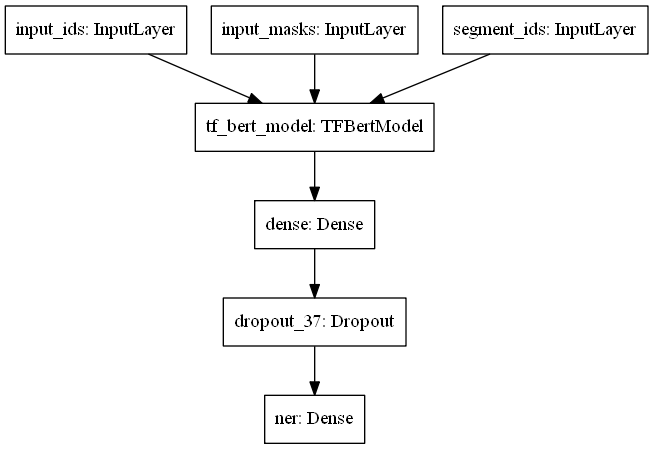

In [43]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

In [44]:
np.array(bert_inputs_train_k).shape, labels_train_k.shape,np.array(bert_inputs_test_k).shape, labels_test_k.shape, 

((3, 47758, 50), (47758, 50), (3, 20364, 50), (20364, 50))

In [45]:
model.fit(
    bert_inputs_train_k, 
    {"ner": labels_train_k },
    validation_data=(bert_inputs_test_k, {"ner": labels_test_k }),
    epochs=5,
    batch_size=16
)

Epoch 1/5
2985/2985 [==============================] - 1348s 451ms/step - loss: 1.0187 - custom_acc_orig_tokens: 0.7589 - custom_acc_orig_non_other_tokens: 0.7589 - val_loss: 0.9944 - val_custom_acc_orig_tokens: 0.7597 - val_custom_acc_orig_non_other_tokens: 0.7597
Epoch 2/5
2985/2985 [==============================] - 1348s 452ms/step - loss: 0.9152 - custom_acc_orig_tokens: 0.7799 - custom_acc_orig_non_other_tokens: 0.7799 - val_loss: 0.2994 - val_custom_acc_orig_tokens: 0.9143 - val_custom_acc_orig_non_other_tokens: 0.9143
Epoch 3/5
2985/2985 [==============================] - 1343s 450ms/step - loss: 0.2378 - custom_acc_orig_tokens: 0.9298 - custom_acc_orig_non_other_tokens: 0.9298 - val_loss: 0.1612 - val_custom_acc_orig_tokens: 0.9503 - val_custom_acc_orig_non_other_tokens: 0.9503
Epoch 4/5
2985/2985 [==============================] - 1339s 449ms/step - loss: 0.1673 - custom_acc_orig_tokens: 0.9491 - custom_acc_orig_non_other_tokens: 0.9491 - val_loss: 0.1353 - val_custom_acc_ori

poch 1/5
2985/2985 [==============================] - 1348s 451ms/step - loss: 1.0187 - custom_acc_orig_tokens: 0.7589 - custom_acc_orig_non_other_tokens: 0.7589 - val_loss: 0.9944 - val_custom_acc_orig_tokens: 0.7597 - val_custom_acc_orig_non_other_tokens: 0.7597
Epoch 2/5
2985/2985 [==============================] - 1348s 452ms/step - loss: 0.9152 - custom_acc_orig_tokens: 0.7799 - custom_acc_orig_non_other_tokens: 0.7799 - val_loss: 0.2994 - val_custom_acc_orig_tokens: 0.9143 - val_custom_acc_orig_non_other_tokens: 0.9143
Epoch 3/5
2985/2985 [==============================] - 1343s 450ms/step - loss: 0.2378 - custom_acc_orig_tokens: 0.9298 - custom_acc_orig_non_other_tokens: 0.9298 - val_loss: 0.1612 - val_custom_acc_orig_tokens: 0.9503 - val_custom_acc_orig_non_other_tokens: 0.9503
Epoch 4/5
2985/2985 [==============================] - 1339s 449ms/step - loss: 0.1673 - custom_acc_orig_tokens: 0.9491 - custom_acc_orig_non_other_tokens: 0.9491 - val_loss: 0.1353 - val_custom_acc_orig_tokens: 0.9585 - val_custom_acc_orig_non_other_tokens: 0.9585
Epoch 5/5
2985/2985 [==============================] - 1344s 450ms/step - loss: 0.1438 - custom_acc_orig_tokens: 0.9563 - custom_acc_orig_non_other_tokens: 0.9563 - val_loss: 0.1232 - val_custom_acc_orig_tokens: 0.9624 - val_custom_acc_orig_non_other_tokens: 0.9624
<tensorflow.python.keras.callbacks.History at 0x29249c137c0>

### V.2. Predictions & Confusion Matrix<a id="confusion" />


Let us look and see how well the model performs. We use the test here. (It probably would be better to split the data into train/validation/test, we are somewhat casual here).

First, get all of the predictions for the test set:

In [46]:
bert_inputs_infer = [X_test[0], X_test[1], X_test[2]]

result = model.predict(
    bert_inputs_infer, 
    batch_size=16
)

In [47]:
print(result.shape)

(20364, 50, 17)


In [48]:
print('True labels')
print(nerLabels_test[6])

True labels
[13  6  3  3  6  6  6  6  6  6  6  8  6  6  6  6  6  6  6  6  6  2  6  6
 16 16 10 10 16  6  6  6  6  1 16 16  6  6  6  6  6  6  8  8  8  8  6  6
 15 14]


In [49]:
print('Predicted labels')
print(np.argmax(result, axis=2)[6])

Predicted labels
[ 6  6  3  3  6  6  6  6  6  6  6  8  6  6  6  6  6  6  6  6  6  2  6  6
  6  6 10 10 10  6  6  6  6  6  6  7  6  6  6  6  6  6  8  8  8  8  6  6
  6  6]


### Now getting confusion matrix


In [50]:
predictions_flat = [pred for preds in np.argmax(result, axis=2) for pred in preds]
labels_flat = [label for labels in nerLabels_test for label in labels]

clean_preds = []
clean_labels = []

for pred, label in zip(predictions_flat, labels_flat):
    if label < 17:
        clean_preds.append(pred)
        clean_labels.append(label)


In [51]:
cm = tf.math.confusion_matrix(
    clean_labels,
    clean_preds,
    num_classes=None,
    dtype=tf.dtypes.int32,
    name=None,
    weights=None
)

In [52]:
np.sum(cm, axis=0)

array([ 19467,   4981,  25063,   6410,   5122,  12074, 782318,   1437,
        77512,   2227,  79194,    173,   2222,      0,      0,      0,
            0])

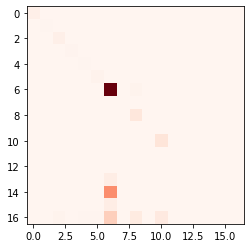

In [53]:
plt.imshow(cm, cmap='Reds')

### To release GPU memory

In [54]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

## Code for RoBerta model

In [39]:
from transformers import TFRobertaModel
def ner_model_ROBERTa(max_input_length, train_layers, optimizer, numclasses):
    """
    Implementation of NER model
    
    variables:
        max_input_length: number of tokens (max_length + 1)
        train_layers: number of layers to be retrained
        optimizer: optimizer to be used
    
    returns: model
    """
    
    in_id = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="segment_ids")
    
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    
    
    # Note: Bert layer from Hugging Face returns two values: sequence ouput, and pooled output. Here, we only want
    # the former. (See https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel) 
    
    bert_layer = TFRobertaModel.from_pretrained('roberta-large')
    
    # Freeze layers, i.e. only train number of layers specified, starting from the top
    
    if not train_layers == -1:
        
        retrain_layers = []
    
        for retrain_layer_number in range(train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)

        for w in bert_layer.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

        # End of freezing section
    
    bert_sequence = bert_layer(bert_inputs)[0]
    
    print('Let us check the shape of the BERT layer output:', bert_sequence)
    
    dense = tf.keras.layers.Dense(256, activation='relu', name='dense')(bert_sequence)
    
    dense = tf.keras.layers.Dropout(rate=0.1)(dense)
    
    pred = tf.keras.layers.Dense(numclasses, activation='softmax', name='ner')(dense)
     
    print('pred: ', pred)
    
    ## Prepare for multipe loss functions, although not used here
    
    losses = {
        "ner": custom_loss,
        }
    lossWeights = {"ner": 1.0
                  }
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

    model.compile(loss=losses, optimizer=optimizer, metrics=[custom_acc_orig_tokens, 
                                                          custom_acc_orig_non_other_tokens])
    
    
    model.summary()
    
    return model

In [40]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [41]:
numclasses = 17
model_Roberta = ner_model_ROBERTa(max_length + 1, train_layers=-1, optimizer = adam_customized, numclasses = numclasses)

model_Roberta.summary()


Some layers from the model checkpoint at roberta-large were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Let us check the shape of the BERT layer output: Tensor("tf_roberta_model/roberta/encoder/layer_._23/output/LayerNorm/batchnorm/add_1:0", shape=(None, 50, 1024), dtype=float32)
pred:  Tensor("ner/truediv:0", shape=(None, 50, 17), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 50)]         0                                            
________________________________________

In [42]:
from keras.utils.vis_utils import plot_model
plot_model(model_Roberta, to_file='model_r.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [43]:
model_Roberta.fit(
    bert_inputs_train_k, 
    {"ner": labels_train_k },
    validation_data=(bert_inputs_test_k, {"ner": labels_test_k }),
    epochs=5,
    batch_size=16
)

Epoch 1/5
2985/2985 [==============================] - 3953s 1s/step - loss: 1.0230 - custom_acc_orig_tokens: 0.7586 - custom_acc_orig_non_other_tokens: 0.7586 - val_loss: 0.9961 - val_custom_acc_orig_tokens: 0.7597 - val_custom_acc_orig_non_other_tokens: 0.7597
Epoch 2/5
2985/2985 [==============================] - 3948s 1s/step - loss: 1.0150 - custom_acc_orig_tokens: 0.7594 - custom_acc_orig_non_other_tokens: 0.7594 - val_loss: 0.9965 - val_custom_acc_orig_tokens: 0.7597 - val_custom_acc_orig_non_other_tokens: 0.7597
Epoch 3/5
2985/2985 [==============================] - 3937s 1s/step - loss: 1.0140 - custom_acc_orig_tokens: 0.7594 - custom_acc_orig_non_other_tokens: 0.7594 - val_loss: 0.9958 - val_custom_acc_orig_tokens: 0.7597 - val_custom_acc_orig_non_other_tokens: 0.7597
Epoch 4/5
2985/2985 [==============================] - 3929s 1s/step - loss: 1.0133 - custom_acc_orig_tokens: 0.7595 - custom_acc_orig_non_other_tokens: 0.7595 - val_loss: 0.9956 - val_custom_acc_orig_tokens: 0.

In [44]:
bert_inputs_infer = [X_test[0], X_test[1], X_test[2]]
result_Roberta = model_Roberta.predict(
    bert_inputs_infer, 
    batch_size=16
)

In [45]:
print('True labels')
print(nerLabels_test[6])

True labels
[13  6  3  3  6  6  6  6  6  6  6  8  6  6  6  6  6  6  6  6  6  2  6  6
 16 16 10 10 16  6  6  6  6  1 16 16  6  6  6  6  6  6  8  8  8  8  6  6
 15 14]


In [46]:
print('Predicted labels - BERT')
print(np.argmax(result, axis=2)[6])
print('Predicted labels - RoBERTa')
print(np.argmax(result_Roberta, axis=2)[6])



Predicted labels - BERT


NameError: name 'result' is not defined

In [ ]:
predictions_flat = [pred for preds in np.argmax(result_Roberta, axis=2) for pred in preds]
labels_flat = [label for labels in nerLabels_test for label in labels]

clean_preds = []
clean_labels = []

for pred, label in zip(predictions_flat, labels_flat):
    if label < 17:
        clean_preds.append(pred)
        clean_labels.append(label)


In [ ]:
cm = tf.math.confusion_matrix(
    clean_labels,
    clean_preds,
    num_classes=None,
    dtype=tf.dtypes.int32,
    name=None,
    weights=None
)

In [ ]:
np.sum(cm, axis=0)

In [ ]:
plt.imshow(cm, cmap='Reds')